In [3]:
# import libraries
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
from torch.optim.lr_scheduler import CosineAnnealingLR

# read the dataset for the Convolutional Neural Network
df = pd.read_pickle('spin_glass_dataset.pkl')

# extract features and targets
J_list = df['J'].values  
T_list = df['T'].values  
energy_list = df['energy'].values  
q_EA_list = df['q_EA'].values  

# conversion in PyTorch tensors
J_tensors = torch.stack([torch.tensor(J, dtype=torch.float32) for J in J_list])
T_tensors = torch.tensor(T_list, dtype=torch.float32).unsqueeze(1)
energy_tensors = torch.tensor(energy_list, dtype=torch.float32).unsqueeze(1)
q_EA_tensors = torch.tensor(q_EA_list, dtype=torch.float32).unsqueeze(1)

# concatenation of energy and q_EA
targets = torch.cat([energy_tensors, q_EA_tensors], dim=1)

# Convolutional Network structure wants "images" of the form (4,6,6)
J_tensors_tp = torch.swapaxes(J_tensors, 2, 3)
J_tensors_tp = torch.swapaxes(J_tensors_tp, 1, 2)

# creation of dataset
dataset = TensorDataset(J_tensors_tp, T_tensors, energy_tensors, q_EA_tensors)

# division in training, validation and test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # 10% for test

train_dataset, temp_dataset = random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# creation of dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# check datasets dimensions
print(f"Cardinality training set: {len(train_dataset)}")
print(f"Cardinality validation set: {len(val_dataset)}")
print(f"Cardinality test set: {len(test_dataset)}")


Cardinality training set: 22960
Cardinality validation set: 6560
Cardinality test set: 3280


In [4]:
# import libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR


# definition of CNN model
class SpinGlassCNN(nn.Module):
    def __init__(self):
        super(SpinGlassCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=0)
        self.fc1 = nn.Linear(129, 20) 
        self.fc4_energy = nn.Linear(20, 1)
        self.fc4_qEA = nn.Linear(20, 1)
        self.leaky_relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        
    def forward(self, J, T):
        x = self.leaky_relu(self.conv1(J))
        x = self.leaky_relu(self.conv2(x))
        x = self.flatten(x)
        # in the Linear layer I add the T information
        x = torch.cat([x, T], dim=1)  
        x = self.leaky_relu(self.fc1(x))
        energy = self.fc4_energy(x)
        qEA = self.fc4_qEA(x)
        return energy, qEA


# set the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move to GPU
model = SpinGlassCNN().to(device)

# compute total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The total number of trainable parameters is: {total_params}")


The total number of trainable parameters is: 7874


In [5]:
# define optimizer, loss function and scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 30

scheduler1 = CosineAnnealingLR(optimizer,T_max=num_epochs,  # Max number of iterations for scheduler
eta_min=1e-8)  # Min learning rate for scheduler


In [6]:
# start the training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for J, T, energy, q_EA in train_loader:
        # move to GPU
        J = J.to(device)
        T = T.to(device)
        energy = energy.to(device)
        q_EA = q_EA.to(device)

        # forward pass
        energy_pred, qEA_pred = model(J, T)

        # compute loss
        loss_energy = criterion(energy_pred, energy)
        loss_qEA = criterion(qEA_pred, q_EA)
        loss = loss_energy + loss_qEA

        # optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    scheduler1.step()

    # print average loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for J, T, energy, q_EA in val_loader:
            J = J.to(device)
            T = T.to(device)
            energy = energy.to(device)
            q_EA = q_EA.to(device)

            energy_pred, qEA_pred = model(J, T)

            loss_energy = criterion(energy_pred, energy)
            loss_qEA = criterion(qEA_pred, q_EA)
            loss = loss_energy + loss_qEA

            val_loss += loss.item()

    print(f'Validation Loss: {val_loss / len(val_loader):.4f}')
from sklearn.metrics import mean_squared_error

Epoch [1/30], Loss: 57.0998
Validation Loss: 13.4027
Epoch [2/30], Loss: 9.9845
Validation Loss: 6.9759
Epoch [3/30], Loss: 6.5522
Validation Loss: 6.3984
Epoch [4/30], Loss: 5.2148
Validation Loss: 8.6421
Epoch [5/30], Loss: 5.0587
Validation Loss: 4.3294
Epoch [6/30], Loss: 4.9378
Validation Loss: 4.9088
Epoch [7/30], Loss: 4.2103
Validation Loss: 3.4923
Epoch [8/30], Loss: 3.9665
Validation Loss: 2.7938
Epoch [9/30], Loss: 3.7937
Validation Loss: 3.5992
Epoch [10/30], Loss: 3.3677
Validation Loss: 4.3902
Epoch [11/30], Loss: 3.6828
Validation Loss: 2.8141
Epoch [12/30], Loss: 3.1029
Validation Loss: 4.1434
Epoch [13/30], Loss: 2.9456
Validation Loss: 2.6206
Epoch [14/30], Loss: 3.1622
Validation Loss: 3.0586
Epoch [15/30], Loss: 2.7076
Validation Loss: 4.5715
Epoch [16/30], Loss: 2.5740
Validation Loss: 2.9761
Epoch [17/30], Loss: 2.3450
Validation Loss: 2.0690
Epoch [18/30], Loss: 2.2454
Validation Loss: 2.1537
Epoch [19/30], Loss: 2.1204
Validation Loss: 2.1641
Epoch [20/30], Loss

In [7]:

model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for J, T, energy, q_EA in test_loader:
        J = J.to(device)
        T = T.to(device)
        energy = energy.to(device)
        q_EA = q_EA.to(device)

        # forward pass
        energy_pred, qEA_pred = model(J, T)

        # append the predictions and targets
        test_preds.append(
            torch.cat((energy_pred.cpu(), qEA_pred.cpu()), dim=1).numpy())  # because numpy only works on cpu
        test_targets.append(torch.cat((energy.cpu(), q_EA.cpu()), dim=1).numpy())

test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

# compute RMSE
rmse_energy = np.sqrt(mean_squared_error(test_targets[:, 0], test_preds[:, 0]))
rmse_q_EA = np.sqrt(mean_squared_error(test_targets[:, 1], test_preds[:, 1]))

print(f"RMSE Energy: {rmse_energy:.4f}")
print(f"RMSE q_EA: {rmse_q_EA:.4f}")


RMSE Energy: 1.2172
RMSE q_EA: 0.1281


41


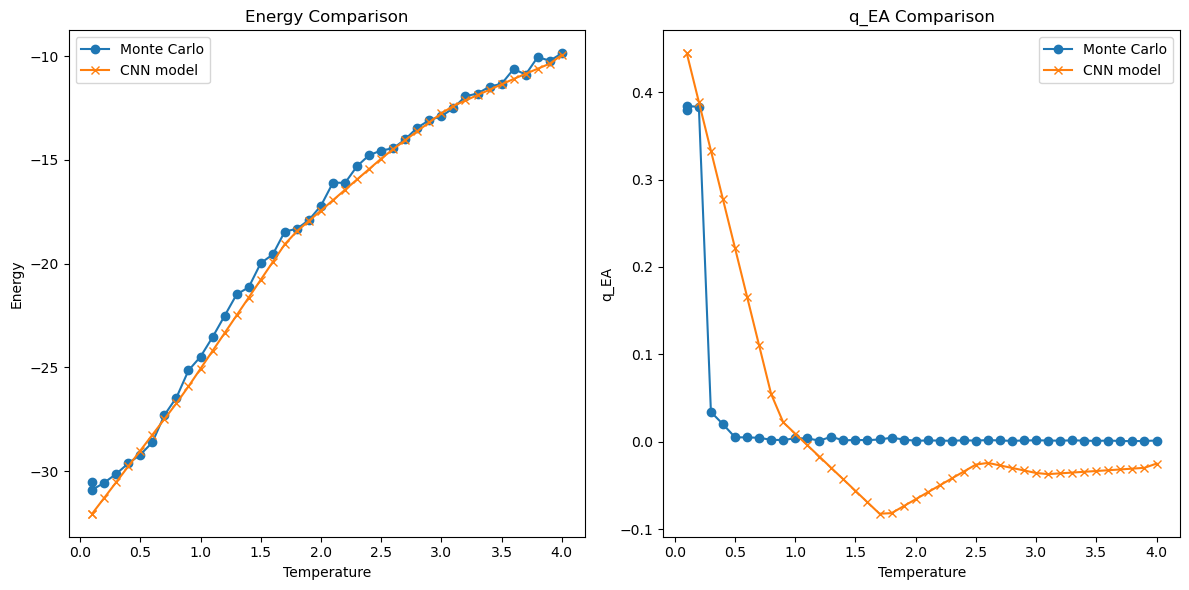

In [9]:
# evaluating the prediction capability with the same code of the Feed Forward Neural Network

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import random


def create_initial_config(N=None):
    states = [-1., 1.]
    config = np.random.choice(states, (N, N))
    return config


def metropolis_single_update(config=None, T=None, J=None):
    N, M = config.shape
    assert N == M, "Wrong configuration shape"
    i = np.random.randint(N)
    j = np.random.randint(M)
    s = config[i, j]
    DeltaE = 2 * s * (J[i, j, 0] * config[i, (j - 1) % N] + J[i, j, 1] * config[i, (j + 1) % N] + J[i, j, 2] * config[
        (i + 1) % N, j] + J[i, j, 3] * config[(i - 1) % N, j])
    effDeltaE = 0
    if DeltaE < 0:
        s *= -1
        effDeltaE = DeltaE
    else:
        if np.random.random() < np.exp(-DeltaE / T):
            s *= -1
            effDeltaE = DeltaE
    config[i, j] = s
    return effDeltaE


def create_vector(N, p):
    dim = (N - 1) * N * 2
    vector = np.ones(dim, dtype=int)
    negative_indices = np.random.choice(dim, p, replace=False)
    vector[negative_indices] = -1
    return vector


def create_spin_glass_dataset(N, v):
    J = np.zeros((N, N, 4), dtype=int)
    count = 0
    for i in range(N):
        for j in range(N):
            if j == 0:
                J[i, j, 0] = 0
            else:
                J[i, j, 0] = J[i, j - 1, 1]
            if j == N - 1:
                J[i, j, 1] = 0
            else:
                J[i, j, 1] = v[count]
                count = count + 1
            if i == 0:
                J[i, j, 2] = 0
            else:
                J[i, j, 2] = J[i - 1, j, 3]
            if i == N - 1:
                J[i, j, 3] = 0
            else:
                J[i, j, 3] = v[count]
                count = count + 1
    return J


def compute_q_EA(config_history):
    N = config_history.shape[1]
    avg_spins = np.mean(config_history, axis=0)
    q_EA = np.sum(avg_spins ** 2) / (N * N)
    return q_EA


def compute_total_energy(config, J):
    N, M = config.shape
    total_energy = 0
    for i in range(N):
        for j in range(M):
            s = config[i, j]
            total_energy -= s * (J[i, j, 0] * config[i, (j - 1) % N] +
                                 J[i, j, 1] * config[i, (j + 1) % N] +
                                 J[i, j, 2] * config[(i + 1) % N, j] +
                                 J[i, j, 3] * config[(i - 1) % N, j])
    return total_energy / 2  



N = 6
T_values = np.arange(4, 0, -0.1)
T_values = np.append(T_values, 0.1)
n_updates = 100000


p = random.choice(range(0, (N - 1) * N * 2 + 1))
v = create_vector(N, p)
J = create_spin_glass_dataset(N, v)


config = create_initial_config(N)
mc_energies = []
mc_q_EAs = []
mc_df = []

for T in T_values:
    total_energy_sum = 0
    config_history = []
    total_measurements = 0

    for k in range(n_updates):
        DeltaE = metropolis_single_update(config, T=T, J=J)
        if k > 10000 and k % 100 == 0:
            config_history.append(config.copy())
            total_energy = compute_total_energy(config, J)
            total_energy_sum += total_energy
            total_measurements += 1

    average_energy = total_energy_sum / total_measurements
    config_history = np.array(config_history)
    q_EA = compute_q_EA(config_history)
    
    mc_energies.append(average_energy)
    mc_q_EAs.append(q_EA)


    mc_df.append({
        'J': J,
        'T': T,
        'energy': average_energy,
        'q_EA': q_EA
    })

mc_df = pd.DataFrame(mc_df)

mc_df = pd.DataFrame(mc_df)
print(len(mc_df['energy'].values))
##############################################

J_list1 = mc_df['J'].values  
T_list1 = mc_df['T'].values  
energy_list1 = mc_df['energy'].values  
q_EA_list1 = mc_df['q_EA'].values  


J_tensors1 = torch.stack([torch.tensor(J, dtype=torch.float32) for J in J_list1])
T_tensors1 = torch.tensor(T_list1, dtype=torch.float32).unsqueeze(1)
energy_tensors1 = torch.tensor(energy_list1, dtype=torch.float32).unsqueeze(1)
q_EA_tensors1 = torch.tensor(q_EA_list1, dtype=torch.float32).unsqueeze(1)


targets1 = torch.cat([energy_tensors1, q_EA_tensors1], dim=1)

J_tensors_tp1 = torch.swapaxes(J_tensors1, 2, 3)
J_tensors_tp1 = torch.swapaxes(J_tensors_tp1, 1, 2)

dataset1 = TensorDataset(J_tensors_tp1, T_tensors1, energy_tensors1, q_EA_tensors1)
############################################

mc_loader = DataLoader(dataset1, batch_size=32, shuffle=False)


model.eval()
energy_preds = []
qEA_preds = []

with torch.no_grad():
    for J, T, energy, q_EA in mc_loader:
    
        J = J.to(device)
        T = T.to(device)
        energy = energy.to(device)
        q_EA = q_EA.to(device)

        
        energy_pred, qEA_pred = model(J, T)
        energy_preds.extend(energy_pred.cpu().numpy())
        qEA_preds.extend(qEA_pred.cpu().numpy())


energy_preds = np.array(energy_preds).flatten()
qEA_preds = np.array(qEA_preds).flatten()

import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(T_list1, mc_energies, label='Monte Carlo', marker='o')
plt.plot(T_list1, energy_preds, label='CNN model', marker='x')
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy Comparison')
plt.legend()

# Plot per q_EA
plt.subplot(1, 2, 2)
plt.plot(T_list1, mc_q_EAs, label='Monte Carlo', marker='o')
plt.plot(T_list1, qEA_preds, label='CNN model', marker='x')
plt.xlabel('Temperature')
plt.ylabel('q_EA')
plt.title('q_EA Comparison')
plt.legend()

plt.tight_layout()
plt.show()